In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Unzip the dataset
import zipfile
import os
zip_file_path = "/content/drive/MyDrive/Brain_Tumor_Detection.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content")


In [3]:
# Specify the root file path
train_dir = "/content/dataset"

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [5]:
# Paths to the dataset
train_dir = '/content/dataset'
img_size = 150  # Image size to resize

# Data Augmentation and Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 1855 images belonging to 2 classes.
Found 463 images belonging to 2 classes.


In [6]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,829,377 (18.42 MB)

 Trainable params: 4,828,929 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
# Callbacks for early stopping and saving the best model
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = ModelCheckpoint('cnn_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5922 - loss: 0.9854
Epoch 1: val_loss improved from inf to 0.66560, saving model to cnn_best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5929 - loss: 0.9841 - val_accuracy: 0.6112 - val_loss: 0.6656
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6883 - loss: 0.6636
Epoch 2: val_loss did not improve from 0.66560
58/58 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6882 - loss: 0.6637 - val_accuracy: 0.4644 - val_loss: 0.8499
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7285 - loss: 0.5733
Epoch 3: val_loss did not improve from 0.66560
58/58 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.7284 - loss: 0.5736 - val_accuracy: 0.4708 - val_loss: 0.8475
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7306 - loss: 0.5291
Epoch 4: val_loss did not improve from 0.66560
58/58 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.7305 - loss: 0.5294 - val_accuracy: 0.6263 - val_lo

15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7217 - loss: 0.5862
Validation Loss: 0.5890840291976929
Validation Accuracy: 0.7149028182029724
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 829ms/step
              precision    recall  f1-score   support

    No Tumor       0.43      0.32      0.37       215
   Yes Tumor       0.51      0.62      0.56       248

    accuracy                           0.48       463
   macro avg       0.47      0.47      0.47       463
weighted avg       0.47      0.48      0.47       463



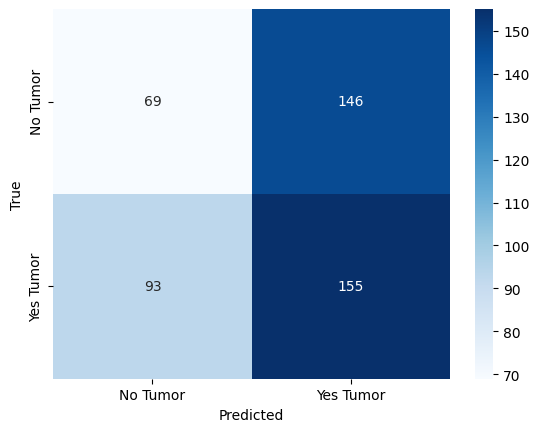

In [9]:
# Load the best model
cnn_model.load_weights('cnn_best_model.keras')

# Evaluate the model
val_loss, val_acc = cnn_model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

# Classification Report and Confusion Matrix
Y_pred = cnn_model.predict(validation_generator)
y_pred = np.round(Y_pred).astype(int)
print(classification_report(validation_generator.classes, y_pred, target_names=['No Tumor', 'Yes Tumor']))

# Confusion Matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['No Tumor', 'Yes Tumor'], yticklabels=['No Tumor', 'Yes Tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


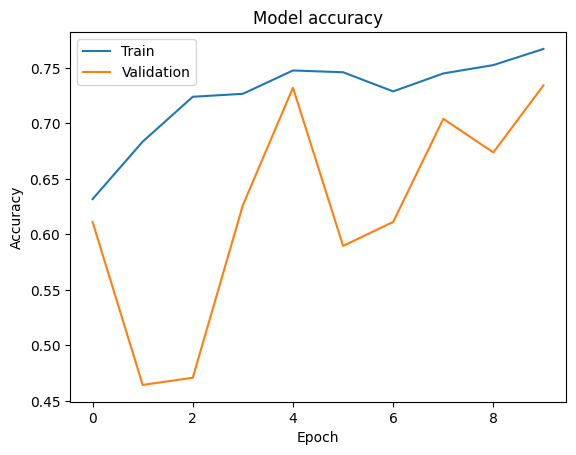

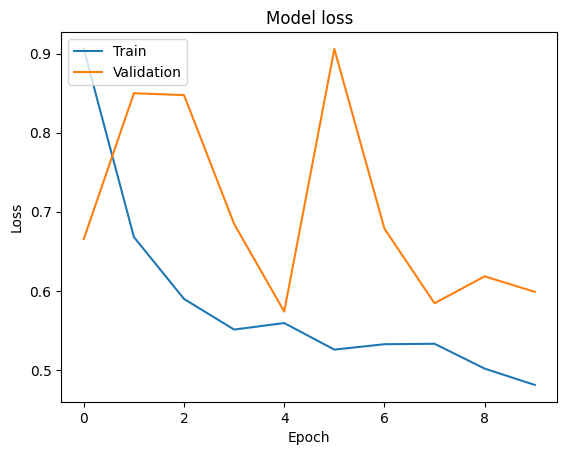

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
